In [1]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from matplotlib.pyplot import specgram
import math
from random import shuffle
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 13

In [2]:
def appendSounds(data,labels,fp):
    X, sr = sf.read(fp)
    sound = np.array(X)
    # librosa operates on (lenght, channels) matrices, wheras soundfile gave us (channels, lenght) 
    # so we transpose
    sound = np.transpose(sound)
    sound = librosa.core.to_mono(sound)
    # resample so every wave has same sampling rate
    sound = librosa.core.resample(sound, sr, 10000)
    # set class number
    classNumber = int(fp.split("/")[1].split("-")[1])
    # compute and set mel spectrogram
    mel = librosa.feature.melspectrogram(sound, sr=10000,n_mels=64, hop_length=506)
    iterator, sliceSize = 0,10
    while iterator+10<=mel.shape[1]:
        data.append(mel[:,iterator:iterator+8].flatten())
        labels.append(classNumber)
        iterator+=8

In [3]:
from multiprocessing import Process, Lock, Pipe,Event
import time
from keras import utils



trainData,trainLabels= [],[]
tuneData,tuneLabels=[],[]
testData,testLabels=[],[]
def add(x,c):
    tempdata,templabels = [],[]
    for file in glob.glob(x):
        appendSounds(tempdata, templabels, file)
    c.send(zip(tempdata, templabels))
    del tempdata,templabels
        
ts = time.time()

if __name__ == '__main__':
    threads= []
    connections=[0]*10
    lock = Lock()
    for x in xrange(1,11):
        connections[x-1], childPipe=Pipe()
        threads.append(Process(target=add, args=("fold"+str(x)+"/*.wav",childPipe)))         
        threads[x-1].start()
    fold = 1
    for x,y in zip(threads,connections):
        tD, tL = zip(*y.recv())
        if fold <= 6:
            trainData += tD
            trainLabels += tL
        elif fold <= 8 :
            tuneData += tD
            tuneLabels += tL
        else:
            testData += tD
            testLabels += tL
        fold+=1
    
    trainData, trainLabels = np.array(trainData), np.array(utils.to_categorical(trainLabels, num_classes=10))
    tuneData, tuneLabels = np.array(tuneData), np.array(utils.to_categorical(tuneLabels, num_classes=10))
    testData, testLabels = np.array(testData), np.array(utils.to_categorical(testLabels, num_classes=10))
    
    print "I'm done, time was:" , time.time()-ts

Using TensorFlow backend.


I'm done, time was: 651.083497047


In [69]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras import regularizers
from random import uniform
from math import pow
rates2 = []

LR,L2= 0.0038,0.00207
net = Sequential()
net.add(Dense(320, activation='relu', input_dim=512,
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.5))
net.add(Dense(120, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.3))
net.add(Dense(60, activation='relu',
             kernel_regularizer=regularizers.l2(L2)))
net.add(Dropout(0.1))
net.add(Dense(10, activation='softmax'))
net.compile(loss='categorical_crossentropy',
           optimizer = SGD(lr=LR,decay=1e-6, momentum=0.9,nesterov=True),
           metrics = ['accuracy'])

net.fit(np.concatenate((trainData,tuneData),axis=0),np.concatenate((trainLabels,tuneLabels),axis=0),
        epochs = 200, batch_size=128, verbose=0)
rates2.append([net.evaluate(testData,testLabels, batch_size=16384)[1],
             net.evaluate(trainData,trainLabels, batch_size=16384)[1],
             LR,L2])
print ("Tune score: %.3f Train score: %.3f Learning rate: %f L2 reg: %f" %(rates2[-1][0],rates2[-1][1],LR, L2))

43690/43690 [==============================] - 0s     
Tune score: 0.516 Train score: 0.762 Learning rate: 0.003800 L2 reg: 0.002070


In [5]:
trainData=np.reshape(trainData,(trainData.shape[0],64,8))
tuneData=np.reshape(tuneData,(tuneData.shape[0],64,8))
trainData=np.expand_dims(trainData,axis=3)
tuneData=np.expand_dims(tuneData,axis=3)
print trainData.shape, tuneData.shape

(43690, 64, 8, 1) (13334, 64, 8, 1)


In [12]:
testData=np.reshape(testData,(testData.shape[0],64,8))
testData=np.expand_dims(testData,axis=3)
testData.shape

(13466, 64, 8, 1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D,BatchNormalization
from keras.optimizers import SGD

model = Sequential()
model.add(ZeroPadding2D(padding = (1,1), input_shape=(64, 8, 1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.7))

model.add(ZeroPadding2D(padding = (1,1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])

model.fit(np.concatenate((trainData,tuneData),axis=0), np.concatenate((trainLabels,tuneLabels),axis=0),
          batch_size=128, epochs=10,verbose=2)
model.evaluate(testData,testLabels, batch_size=64,verbose=2)

Epoch 1/10
165s - loss: 1.7819 - acc: 0.3937
Epoch 2/10
164s - loss: 1.3871 - acc: 0.5199
Epoch 3/10
164s - loss: 1.2233 - acc: 0.5806
Epoch 4/10
164s - loss: 1.1106 - acc: 0.6227
Epoch 5/10
164s - loss: 1.0247 - acc: 0.6562
Epoch 6/10
165s - loss: 0.9680 - acc: 0.6765
Epoch 7/10
164s - loss: 0.9166 - acc: 0.6922
Epoch 8/10
164s - loss: 0.8800 - acc: 0.7044
Epoch 9/10
164s - loss: 0.8401 - acc: 0.7149
Epoch 10/10
164s - loss: 0.8177 - acc: 0.7252


[2.0316865287978989, 0.43115995841378285]

In [7]:
model.evaluate(tuneData,tuneLabels, batch_size=8,verbose=2)

1.8880208947968051

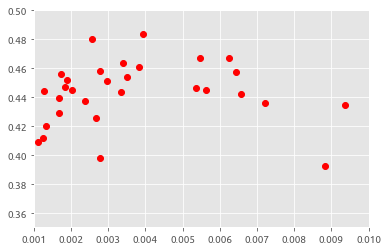

In [43]:
plt.plot(rates[:,2],rates[:,0],'ro')
plt.axis([0.001,0.01,0.35,0.5])
plt.show()
#128 batch - f(learning_Rate)=score

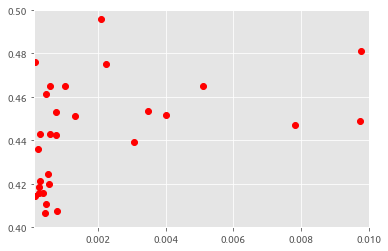

In [50]:
plt.plot(rates1[:,3],rates1[:,0],'ro')
plt.axis([0.0001,0.01,0.4,0.5])
plt.show()
#128 batch - f(L2 lambda)=score, lr=0.0038

In [67]:
rates

array([[ 0.46332684,  0.64337377,  0.00340095,  0.00615   ],
       [ 0.39223039,  0.58867017,  0.00883593,  0.00615   ],
       [ 0.46700165,  0.63909361,  0.00624703,  0.00615   ],
       [ 0.420279  ,  0.57713435,  0.00132861,  0.00615   ],
       [ 0.45815209,  0.63666742,  0.00277255,  0.00615   ],
       [ 0.44697765,  0.59986267,  0.00184628,  0.00615   ],
       [ 0.43692815,  0.62783246,  0.00236223,  0.00615   ],
       [ 0.40910456,  0.54048981,  0.00111271,  0.00615   ],
       [ 0.48005101,  0.62009614,  0.00255855,  0.00615   ],
       [ 0.4460777 ,  0.63117418,  0.00535054,  0.00615   ],
       [ 0.43947804,  0.60407416,  0.00167252,  0.00615   ],
       [ 0.45350233,  0.64344243,  0.00349331,  0.00615   ],
       [ 0.43602821,  0.62451363,  0.00722168,  0.00615   ],
       [ 0.44465277,  0.6237583 ,  0.00562414,  0.00615   ],
       [ 0.42875355,  0.58432136,  0.00168327,  0.00615   ],
       [ 0.41180441,  0.50856031,  0.00125626,  0.00615   ],
       [ 0.45747712,  0.

In [23]:
mean = 0
for x in trainData:
    mean+=np.mean(x)
mean/=len(trainData)
for i in xrange (len(trainData)):
    trainData[i]-=mean
for i in xrange (len(testData)):
    testData[i]-=mean
print np.mean(testData[767])

-2.32882498905


In [69]:
print score

[2.0773913470494461, 0.4402383750109779]
